In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

In [3]:
variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# combine datasets just to pick first member and it gets naming the way i want
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [4]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].sel(y = slice(-80,-30)).areacello
# # A2 = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello
# # A


# newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords1 = {'x':A['x'], 'y':A['y']}
newcoords1

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 50)>
 array([-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5])
 Coordinates:
   * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
 Attributes:
     axis:           Y
     bounds:         lat_bnds
     cell_methods:   time: point


In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn

# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item['mlotst']).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 17
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


['CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [6]:
variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr

# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid2={}
for name,item in dd_gr.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item['mlotst']).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 11
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 11
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 11
  tmp = blockwise(


['CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [7]:
dd_mlotst = {**dd_regrid2, **dd_regrid}
list(dd_mlotst.keys())

['CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [77]:
# for name, ds in dd_mlotst.items():
#     ds = ds.isel(time = slice(0,239))
#     ds = ds.sel(time=ds.time.dt.season=="JJA").mean('time',keep_attrs=True)
#     dd_mlotst[name] = ds
dd_annual = {}
dd_JJA = {}
for name, ds in dd_mlotst.items():
    ds = ds.isel(time = slice(0,239)).sel(y = slice(-80,-30))
    ds_ann = ds.mean(['time'],keep_attrs=True)
    ds_JJA = ds.sel(time=ds.time.dt.season=="JJA").mean(['time'],keep_attrs=True)
    dd_annual[name] = ds_ann + 100
    dd_JJA[name] = ds_JJA + 100

In [9]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
# A = xr.open_mfdataset('AREA.nc')

In [10]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords1)

In [11]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    ds['sigma1'] = gsw.sigma1(ds['so'],ds['thetao'])

In [12]:
for name, ds in dd.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    # ds['PCO2'] = results['pCO2_out']
    # ppco2 = ds.dissic.copy(data=results['pCO2_out'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])



In [78]:
for name, ds in dd_annual.items():
    dd_annual[name] = ds.assign_coords(**newcoords1)
for name, ds in dd_JJA.items():
    dd_JJA[name] = ds.assign_coords(**newcoords1)

In [79]:
ML = {}
ML_JJA = {}

for name, ds in dd.items():
    ds = ds.PCO2
    # if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
    #     ML[name] = ds.sel(lev = dd_annual[name].mlotst, method = 'nearest')
    #     ML_JJA[name] = ds.sel(lev = dd_JJA[name].mlotst, method = 'nearest')
    if name != 'GFDL-CM4.gr.historical.Omon':
        ML[name] = ds.sel(lev = dd_annual[name], method = 'nearest')
        ML_JJA[name] = ds.sel(lev = dd_JJA[name], method = 'nearest')

# Winter mixed layer + 100 meters

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python

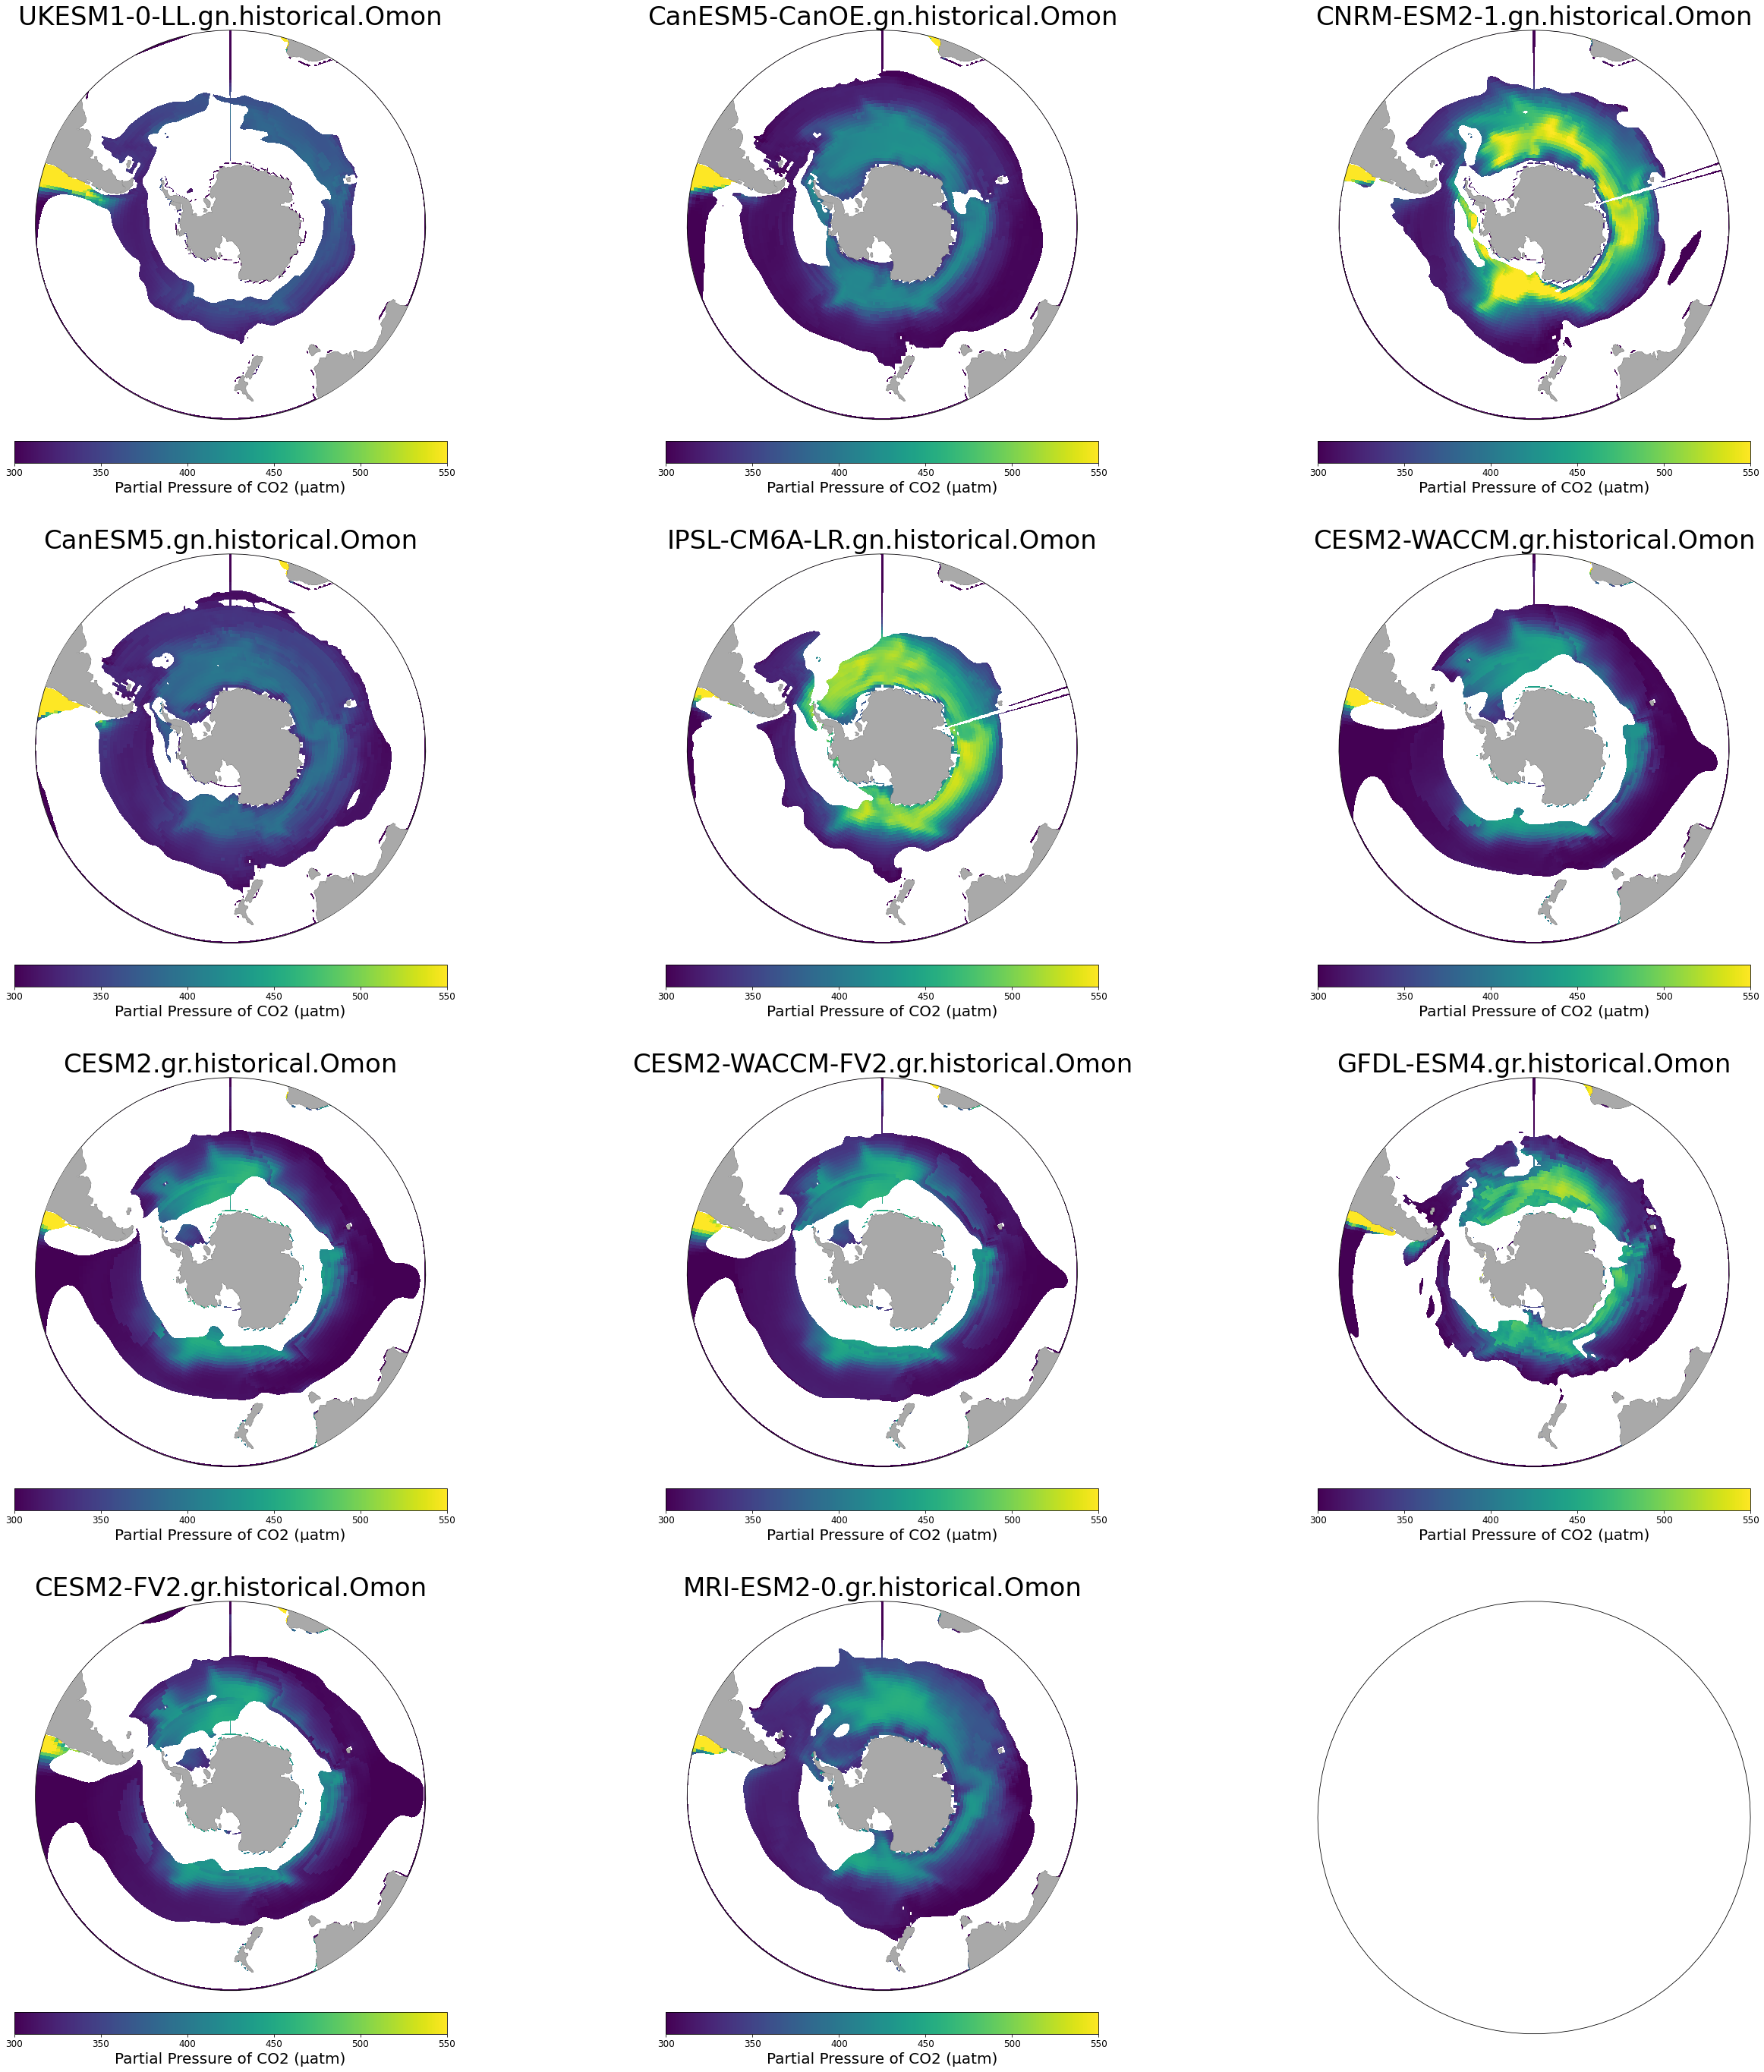

In [88]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in ML.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=34,pad = 1)
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = ds
    Z2 = dd[name].fgco2 * conversion
    # rho = ds['sigma0'].isel(lev = 0)
    # rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 300, vmax = 550)
    im2 = ax.contourf(X,Y,Z2, transform = crs_source, levels=[0,10],colors='w', linewidths = 3)
    # if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
    #     CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    # else:
    #     CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    
    cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


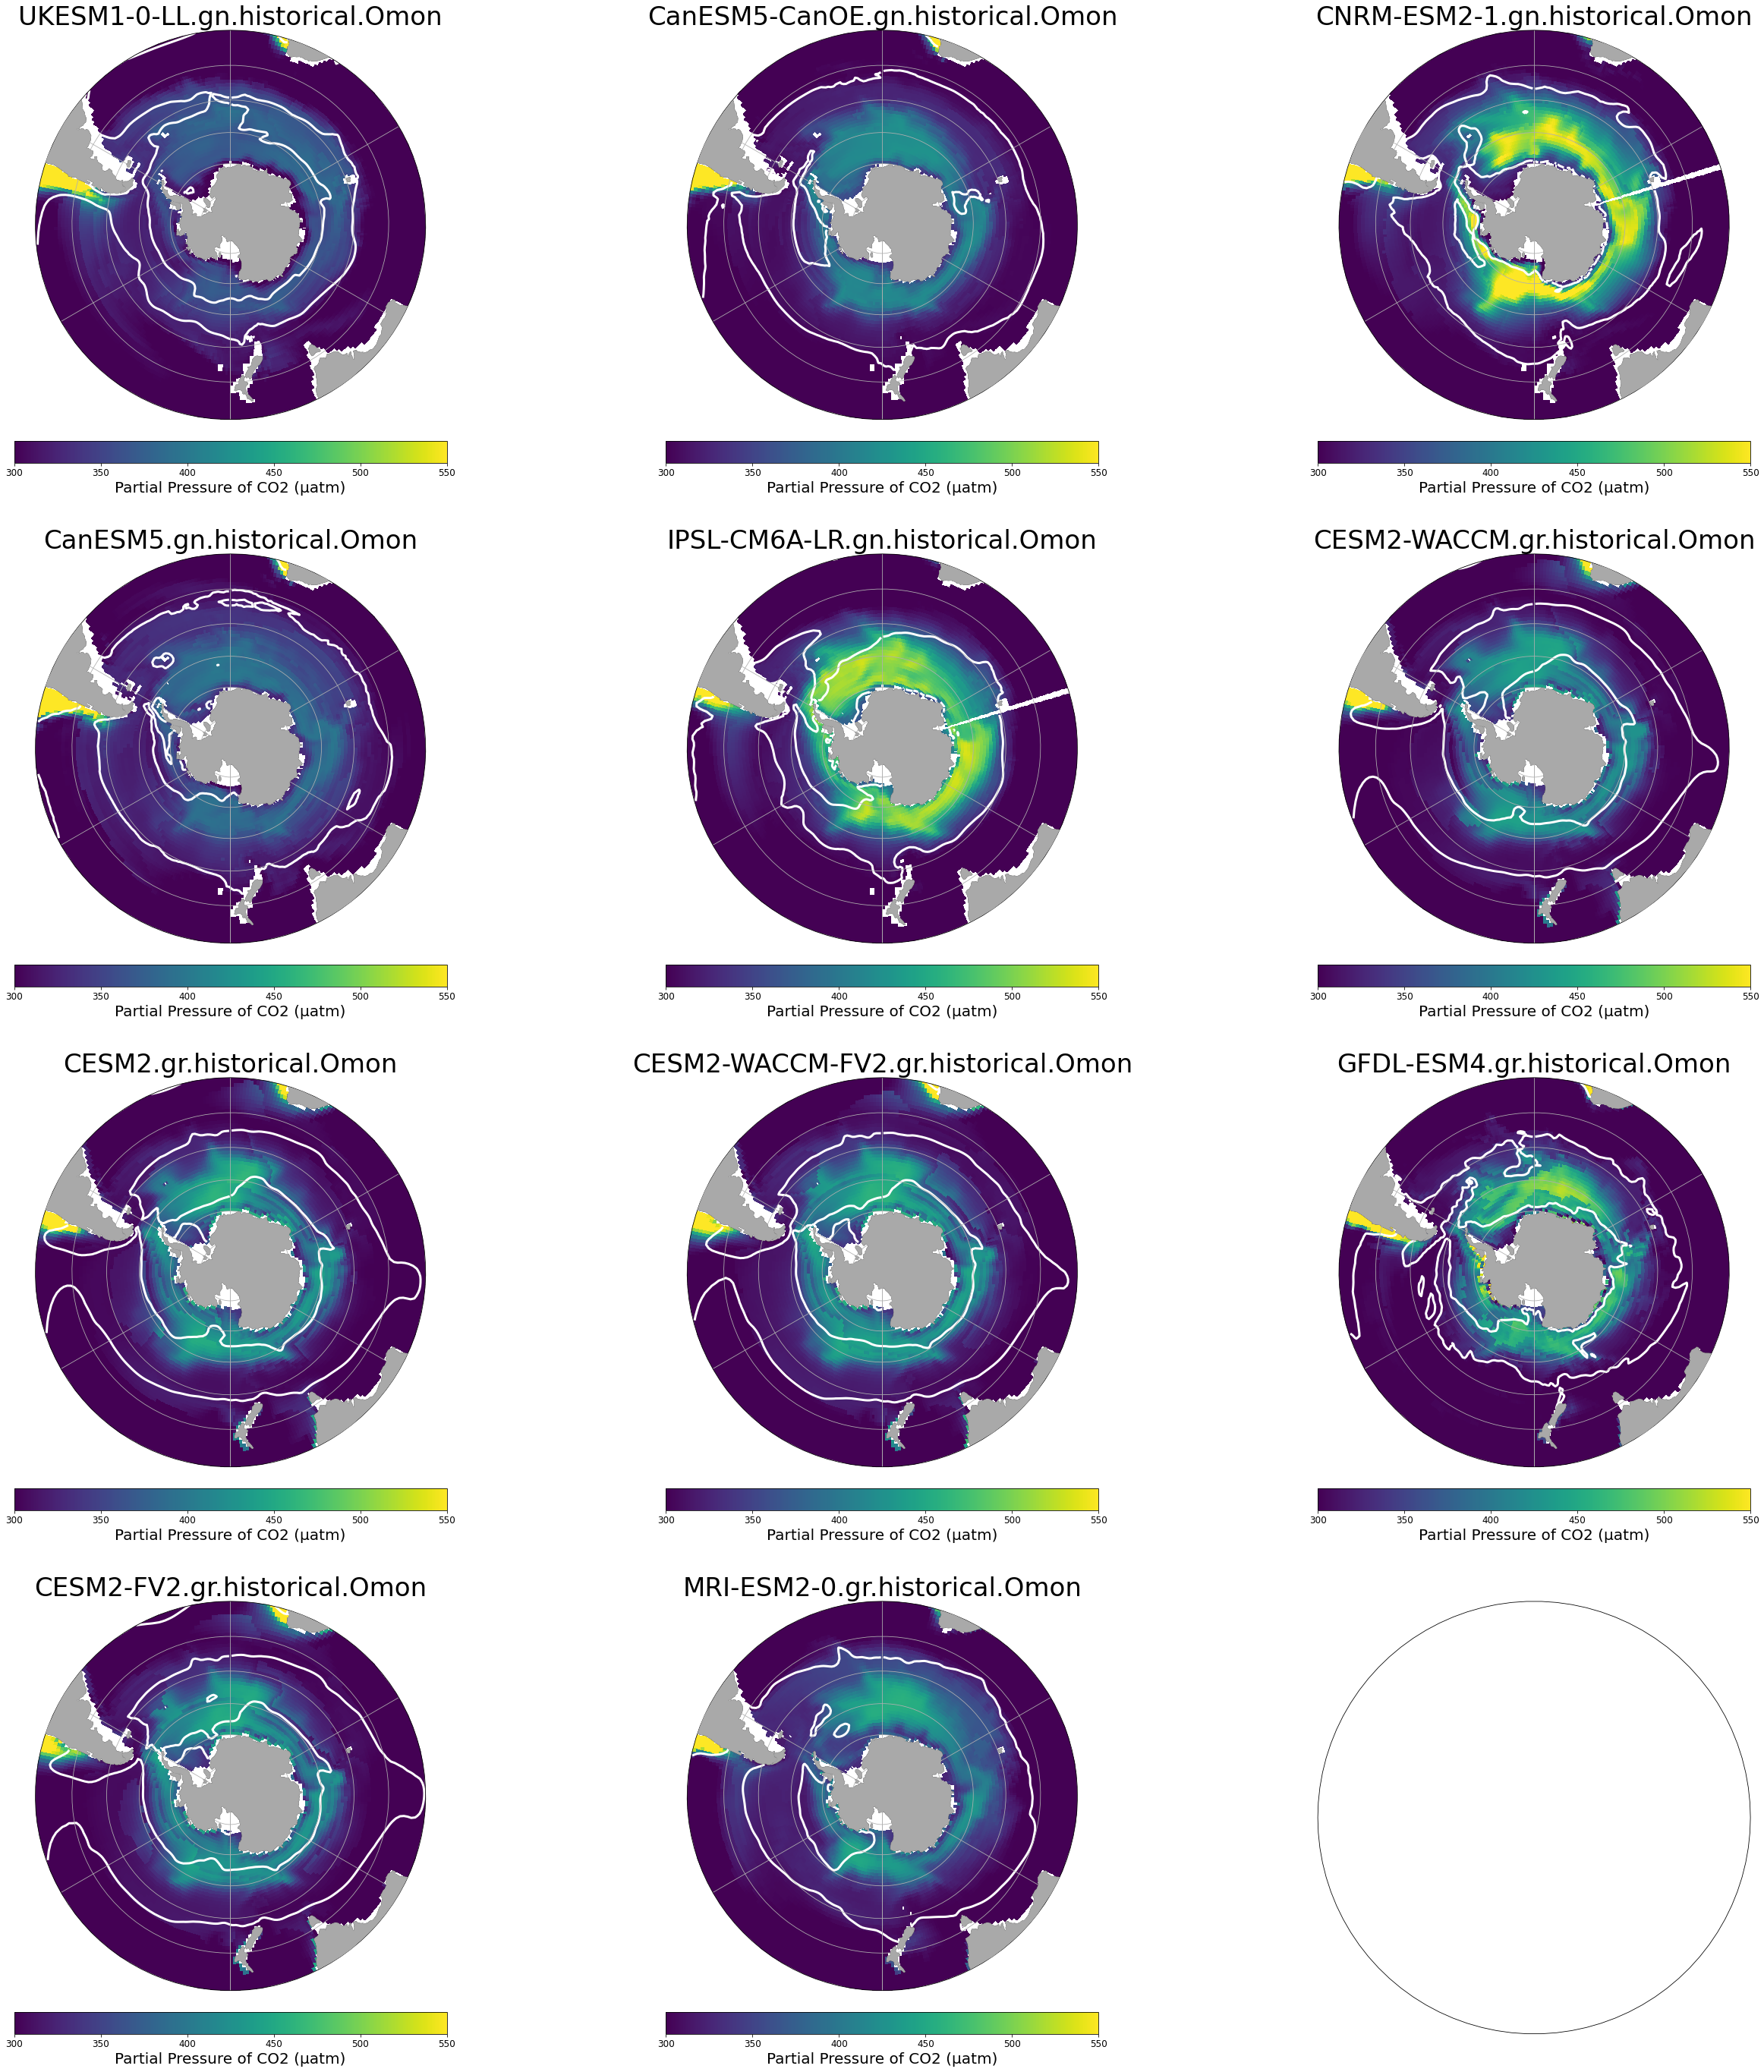

In [82]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in ML.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=34,pad = 1)
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = ds
    Z2 = dd[name].fgco2 * conversion
    # rho = ds['sigma0'].isel(lev = 0)
    # rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 300, vmax = 550)
    im2 = ax.contour(X,Y,Z2, transform = crs_source, levels=[0],colors='w', linewidths = 3)
    # if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
    #     CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    # else:
    #     CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    
    cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


In [45]:
dd['CESM2-FV2.gr.historical.Omon'].fgco2

<xarray.DataArray 'fgco2' (y: 50, x: 360)>
dask.array<getitem, shape=(50, 360), dtype=float32, chunksize=(50, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
    lat      (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
Attributes: (12/20)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Gas exchange flux of CO2 (positive into ocean)
    frequency:      mon
    id:             fgco2
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
    type:           real
    variable_id:    fgco2
    units:          kg/m²/s

In [46]:
ML['CESM2-FV2.gr.historical.Omon']

<xarray.DataArray 'PCO2' (y: 50, x: 360)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [285.82177118, 286.38815245, 287.04499298, ..., 284.28961036,
        284.80696216, 285.30663973],
       [283.33165769, 283.9132313 , 284.63230969, ..., 281.61352774,
        282.20403527, 282.78104781],
       [281.48618213, 282.33242981, 283.31982546, ..., 279.20113156,
        279.90138837, 280.67775125]])
Coordinates:
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
    lat      (x, y) float64 dask.array<chunksize=(360, 50), meta=np.ndarray>
    lev      (y, x) float64 500.0 500.0 500.0 500.0 ... 125.0 125.0 125.0 125.0
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Dissolved inorganic carbon (CO3+HCO3+H2CO3) concentration
    frequency:      mon
    id:             dissic
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Dissolved Inorganic Carbon Concentration
    type:           real
    variable_id:    dissic
    units:          mol/m³

In [52]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

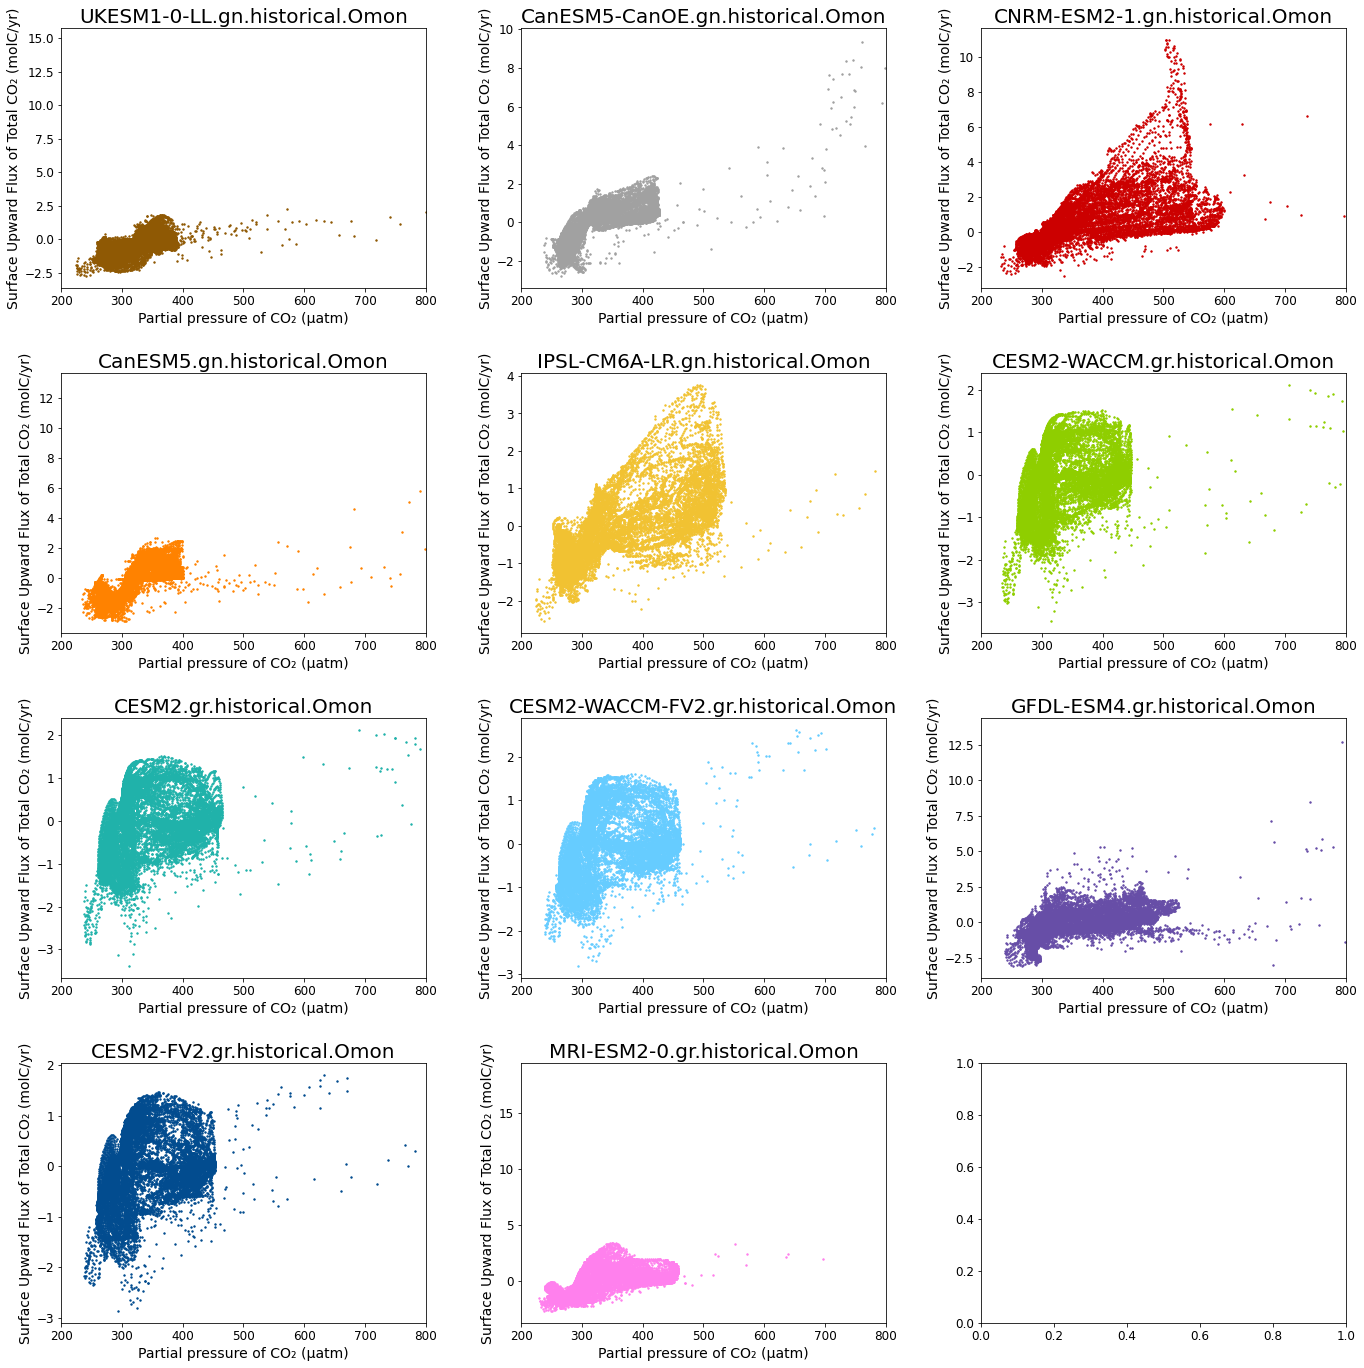

In [85]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[20,20])
fig.tight_layout(pad = 5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=16)
# crs_plot = ccrs.SouthPolarStereo()
# crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in ML.items():

    ax = axarr.flat[ax_idx]
    conversion = 3.1536e7 * 83.3
    ax.scatter(ds, -1*conversion*dd[name].fgco2, s = 2, **model_kwargs[name])
    
    # z = np.polyfit(ds, -1*conversion*dd[name].fgco2, 1)
    # p = np.poly1d(z)
    # ax.plot(p(x),"k--")
    
    title=name
    ax.set_title(title,fontsize=20,pad = 5)
    ax.set_xlim([200,800])
    
    ax.set_xlabel('Partial pressure of CO\u2082 (\u03BCatm)', fontsize = 14)
    ax.set_ylabel('Surface Upward Flux of Total CO\u2082 (molC/yr)', fontsize = 14)
    
#     im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 300, vmax = 450)
#     im2 = ax.contour(X,Y,Z2, transform = crs_source, levels=[0],colors='w', linewidths = 3)
#     # if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
#     #     CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
#     # else:
#     #     CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    
#     cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
#     cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


In [75]:
ds

<xarray.DataArray 'PCO2' (y: 50, x: 360)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [261.36719443, 259.24746383, 258.68887367, ..., 262.95876448,
        262.20888261, 263.23138132],
       [259.56736615, 257.47561833, 257.12457881, ..., 261.50751584,
        260.57143873, 261.47807176],
       [258.0419151 , 256.09820301, 254.18728669, ..., 260.12084452,
        259.02527892, 259.8878125 ]])
Coordinates:
    lev      (y, x) float64 457.6 457.6 457.6 457.6 ... 108.0 108.0 108.0 120.0
    lon      (y, x) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
    lat      (y, x) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5